In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

%matplotlib inline

In [2]:
def pdftarget(x, normed=1):
    return np.exp(0.4*(x - 0.4)*(x - 0.4) - 0.08*x*x*x*x)/normed

In [3]:
def propos(x, xmin, xmax, xhigh, yhigh):
    m1 = yhigh/(xhigh - xmin)
    c1 = -xmin*m1
    m2 = -yhigh/(xmax - xhigh)
    c2 = -xmax*m2
    y = np.where(x < xhigh, m1*x + c1, m2*x + c2)
    return y

In [4]:
def sampling_isosceles(nsamples, normalize, xmin, xmax, xhigh, yhigh):   
    # start sampling
    u = np.random.random(nsamples)
    v = np.random.random(nsamples)
    low = 0.5*xmin
    width = 0.5*(xmax-xmin)
    x = low + width*u
    y = low + width*v
    xsample = x + y # "Fourier convolution" to make an isosceles triangle
    target_dist = pdftarget(xsample, normed=normalize)
    ysample = propos(xsample, xmin, xmax, xhigh, yhigh)*np.random.random(nsamples)
    
    accept = ysample <= target_dist
    
    return xsample, ysample, accept

Accepting rate:  0.302


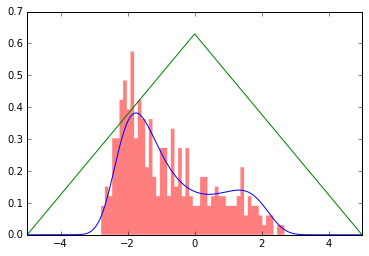

In [5]:
xmin, xmax = -5, 5
I = quad(pdftarget, -100, 100)
nsamples = 1000
xhigh = 0.0
yhigh = 0.63
xsample, ysample, accept = sampling_isosceles(nsamples, I[0], xmin, xmax, xhigh, yhigh)

xaccept = xsample[accept]
print "Accepting rate: ", float(len(xaccept))/len(xsample)

x = np.linspace(xmin, xmax, 1000)
y_target = pdftarget(x, normed=I[0])
y_propos = propos(x, xmin, xmax, xhigh, yhigh)
plt.plot(x, y_target)
plt.plot(x, y_propos)
plt.hist(xaccept, normed=True, bins=50, histtype="stepfilled", color="red", alpha=0.5, linewidth=0)
plt.xlim([xmin, xmax])
plt.show()

### Let's try to make it more efficient

NOTE: efficiency in accepting rate! not necessarily in computing time (need more testing)

In [6]:
def sampling_piecewise(nsamples, normalize, xmin, xmax, xhigh, yhigh):   
    l1 = 0.5*(xhigh-xmin)*yhigh # left triangle area
    l2 = 0.5*(xmax-xhigh)*yhigh # right triangle area
    l = l1+l2 # total area
    
    # start sampling
    # piecewise proposal distribution
    xsample1 = xmin + (xhigh-xmin)*np.sqrt(np.random.random(int(nsamples*l1/l))) # left triangle
    xsample2 = xmax - (xmax-xhigh)*np.sqrt(np.random.random(int(nsamples*l2/l))) # right triangle
    xsample = np.append(xsample1, xsample2)
    np.random.shuffle(xsample) # shuffle this array (for animation purpose)
    
    n = len(xsample) # may change a little
    target_dist = pdftarget(xsample, normed=normalize)
    ysample = propos(xsample, xmin, xmax, xhigh, yhigh)*np.random.random(n)
    
    accept = ysample <= target_dist
    
    return xsample, ysample, accept, l, n

In [7]:
xmin, xmax = -5, 5
I = quad(pdftarget, -100, 100)
nsamples = 1000

x = np.linspace(xmin, xmax, 1000)
y_target = pdftarget(x, normed=I[0])
high = np.argmax(y_target)
xhigh = x[high]
yhigh = y_target[high]
print xhigh, yhigh

-1.75675675676 0.382082506929


Accepting rate:  0.518518518519


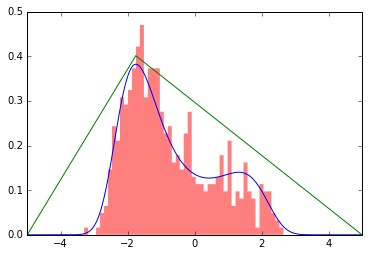

In [8]:
xsample, ysample, accept, l, n = sampling_piecewise(nsamples, I[0], xmin, xmax, xhigh, 1.05*yhigh)
xaccept = xsample[accept]
print "Accepting rate: ", float(len(xaccept))/len(xsample)

y_propos = propos(x, xmin, xmax, xhigh, 1.05*yhigh)
plt.plot(x, y_target)
plt.plot(x, y_propos)
plt.hist(xaccept, normed=True, bins=50, histtype="stepfilled", color="red", alpha=0.5, linewidth=0)
plt.xlim([xmin, xmax])
plt.show()

### Make an animation

In [9]:
def plot_samples(xsample, ysample, accept, normalize, xhigh, yhigh, xmin=-5, xmax=5, nbins=50, write=False, filename='plot_rejection_sampling.png', trace=False):
    nsamples = len(xsample)
    ofile = '/home/ridlo/project/stats/rejection_sampling/'+filename
    
    xaccept = xsample[accept]
    n_accept = len(xaccept)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(xmin, xmax)
    
    x = np.linspace(xmin, xmax, 1000) # draw target dist line
    target_dist = pdftarget(x, normed=normalize)
    propos_dist = propos(x, xmin, xmax, xhigh, yhigh)
    
    ymax = 1.1*np.amax(propos_dist)
    ax.set_ylim(0, ymax)
    
    ax.plot(x, target_dist, 'k')
    ax.plot(x, propos_dist, 'g')
    
    if nsamples > 0:
        if n_accept > 0:
            ax.hist(xaccept, normed=True, bins=nbins, histtype="stepfilled", color="blue", alpha=0.5, linewidth=0)
    
            if trace:
                sample_x = xsample[-1] # last sample 
                sample_y = ysample[-1]
                sample_accept = accept[-1]
                ax.axvline(x=sample_x, ymin=0, ymax=(sample_y)/(ymax), c='k')
                ax.axhline(y=sample_y, xmin=xmin, xmax=(sample_x-xmin)/(xmax-xmin), c='k')
                if sample_accept:
                    ax.plot(sample_x, sample_y, 'k.')
                else:
                    ax.plot(sample_x, sample_y, 'r.')

            rate_accept = float(n_accept)/float(nsamples)
            text = r'$n_{sample} = '+'{0:d}$'.format(nsamples)+'\n'
            text += r'$r_{accept} = '+'{0:0.2f}$'.format(rate_accept)
            ax.annotate(text, xy=(0.7, 0.97), xycoords='axes fraction', ha='left', va='top') 
    
    if write:
        plt.savefig(ofile, bbox_inches='tight', dpi=400); plt.close()
    else:
        plt.show(); plt.close()

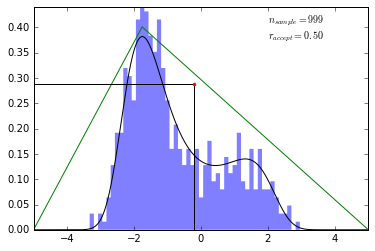

In [10]:
# test
xmin, xmax = -5, 5
I = quad(pdftarget, -100, 100)
nsamp = 1000

x = np.linspace(xmin, xmax, 1000)
y_target = pdftarget(x, normed=I[0])
high = np.argmax(y_target)
xhigh = x[high]
yhigh = y_target[high]

xsample, ysample, accept, l, n = sampling_piecewise(nsamples, I[0], xmin, xmax, xhigh, 1.05*yhigh)
plot_samples(xsample, ysample, accept, I[0], xhigh, 1.05*yhigh, trace=True)

In [11]:
# animation plot
# make an animation
divisor = 10
for i in range(n):
    plot_samples(xsample[0:i], 
                 ysample[0:i], 
                 accept[0:i], 
                 I[0], 
                 xhigh, 
                 1.05*yhigh,
                 write=True,
                 filename='plotsample_nsamp_{0:04d}.png'.format(i),
                 trace=True)
    
    if (((i+1) % divisor) == 0):
        print ".",

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [12]:
from IPython.display import YouTubeVideo

In [14]:
YouTubeVideo("Pk2pSMDIXww")

### References

- SEAYAC Workshop, *MC methods in astronomy*, Tri L. Astraatmadja (MPIA Heidelberg)
    Krabi, 4 December 2015